# The Bayesian Lasso Regression

Similarly to simple linear regression, the lasso regression can also be viewed from Bayesian point of view

## Import Dependencies and Workflow Set-ups

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import pymc3 as pm
import warnings
seed = 2127

# the lines below are purely for aesthetics
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.dpi']= 100

# Hide ONLY deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**note**

The package `pymc3` is not installed by default with Anaconda installation. For Windows, installation is trivial by using conda. For MacOS (particularly if you are using arm chip), refer to https://github.com/pymc-devs/pymc/wiki/Installation-Guide-(MacOS)

## Univariate Bayesian Lasso Regression

In this section, both Bayesian estimates for lasso regression and frequentist lasso fit will be exercised to develop a univariate model. The goal is to predict production by using permeability. 

### Read Data and Standardization

In [4]:
data = pd.read_csv("unconv_MV_v4.csv")
scaler = StandardScaler()
dataSt = pd.DataFrame(scaler.fit_transform(data))
dataSt.columns = data.columns
dataSt.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,-1.723412,-0.982256,-0.817030,-0.298603,2.358297,0.352948,1.152048,-1.399936
1,-1.706091,-0.881032,-0.463751,0.444147,-0.141332,-0.209104,-0.280931,-0.553322
2,-1.688771,-0.327677,-1.008148,1.841224,1.748113,-0.209104,2.518377,-0.859996
3,-1.671450,0.903875,1.401098,-0.599240,-0.592585,0.186414,-0.280931,0.919141
4,-1.654129,0.853263,0.138561,0.373409,-2.640962,1.081534,-0.214280,-0.648602


In [29]:
dataSt.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,200.0,-6.661338e-18,1.002509,-1.723412,-0.861706,0.000000,0.861706,1.723412
Por,200.0,2.620126e-16,1.002509,-2.848142,-0.701361,0.026605,0.813617,2.887855
Perm,200.0,-5.662137e-17,1.002509,-1.853701,-0.699753,-0.171282,0.554098,3.208033
AI,200.0,3.985701e-16,1.002509,-2.986650,-0.745137,-0.024493,0.665203,2.937664
Brittle,200.0,1.824929e-16,1.002509,-2.640962,-0.738391,0.095646,0.716652,2.566186
TOC,200.0,3.552714e-16,1.002509,-2.457313,-0.776361,0.082330,0.748466,2.476256
VR,200.0,9.126033e-16,1.002509,-3.446814,-0.647507,-0.014330,0.593853,3.018254
Prod,200.0,7.549517e-17,1.002509,-1.952114,-0.760415,-0.167875,0.573278,3.050219


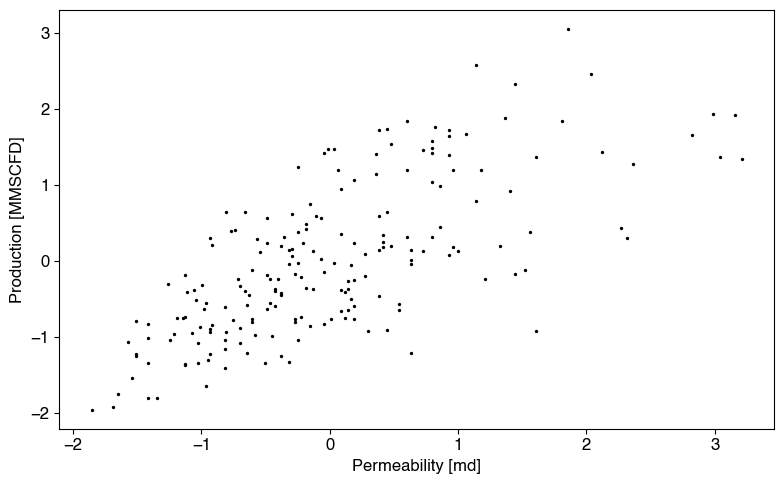

In [64]:
x = dataSt["Perm"]
y = dataSt["Prod"]

plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", s = 2)
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plt.tight_layout()
plt.show()

### Building the Bayesian Lasso Model

In [56]:
lambd = 0.1

with pm.Model() as bayesLassoUni:
    # declare priors
    intercept = pm.Flat("intercept")
    sigmaSq = pm.Exponential("sigma2", lam = 1)
    beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/lambd)
    
    # construct model
    modelMean = intercept + (beta * x)
    
    # define likelihood
    likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)
    
    # set up posterior sampling 
    step = pm.NUTS(target_accept = 0.95)
    
    # get trace and maximum a posteriori (MAP)
    trace = pm.sample(draws = 1000, tune = 1000, step = step, 
                      random_seed = seed, return_inferencedata = True)
    posteriorMode = pm.find_MAP()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


The mode of the posterior (a.k.a the Bayesian lasso point estimates for the parameters)

In [49]:
print(posteriorMode)

{'intercept': array(1.45462877e-16), 'sigma2_log__': array(-0.69727269), 'beta': array(0.70486915), 'sigma2': array(0.49794149)}


The summary statistics for the posterior and the diagnostic plots

In [50]:
with bayesLassoUni:
    print(pm.stats.summary(trace))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.001  0.050  -0.097    0.091      0.001    0.001    3718.0   
beta       0.706  0.051   0.613    0.800      0.001    0.001    3703.0   
sigma2     0.512  0.053   0.421    0.618      0.001    0.001    3235.0   

           ess_tail  r_hat  
intercept    2653.0    1.0  
beta         2635.0    1.0  
sigma2       2969.0    1.0  


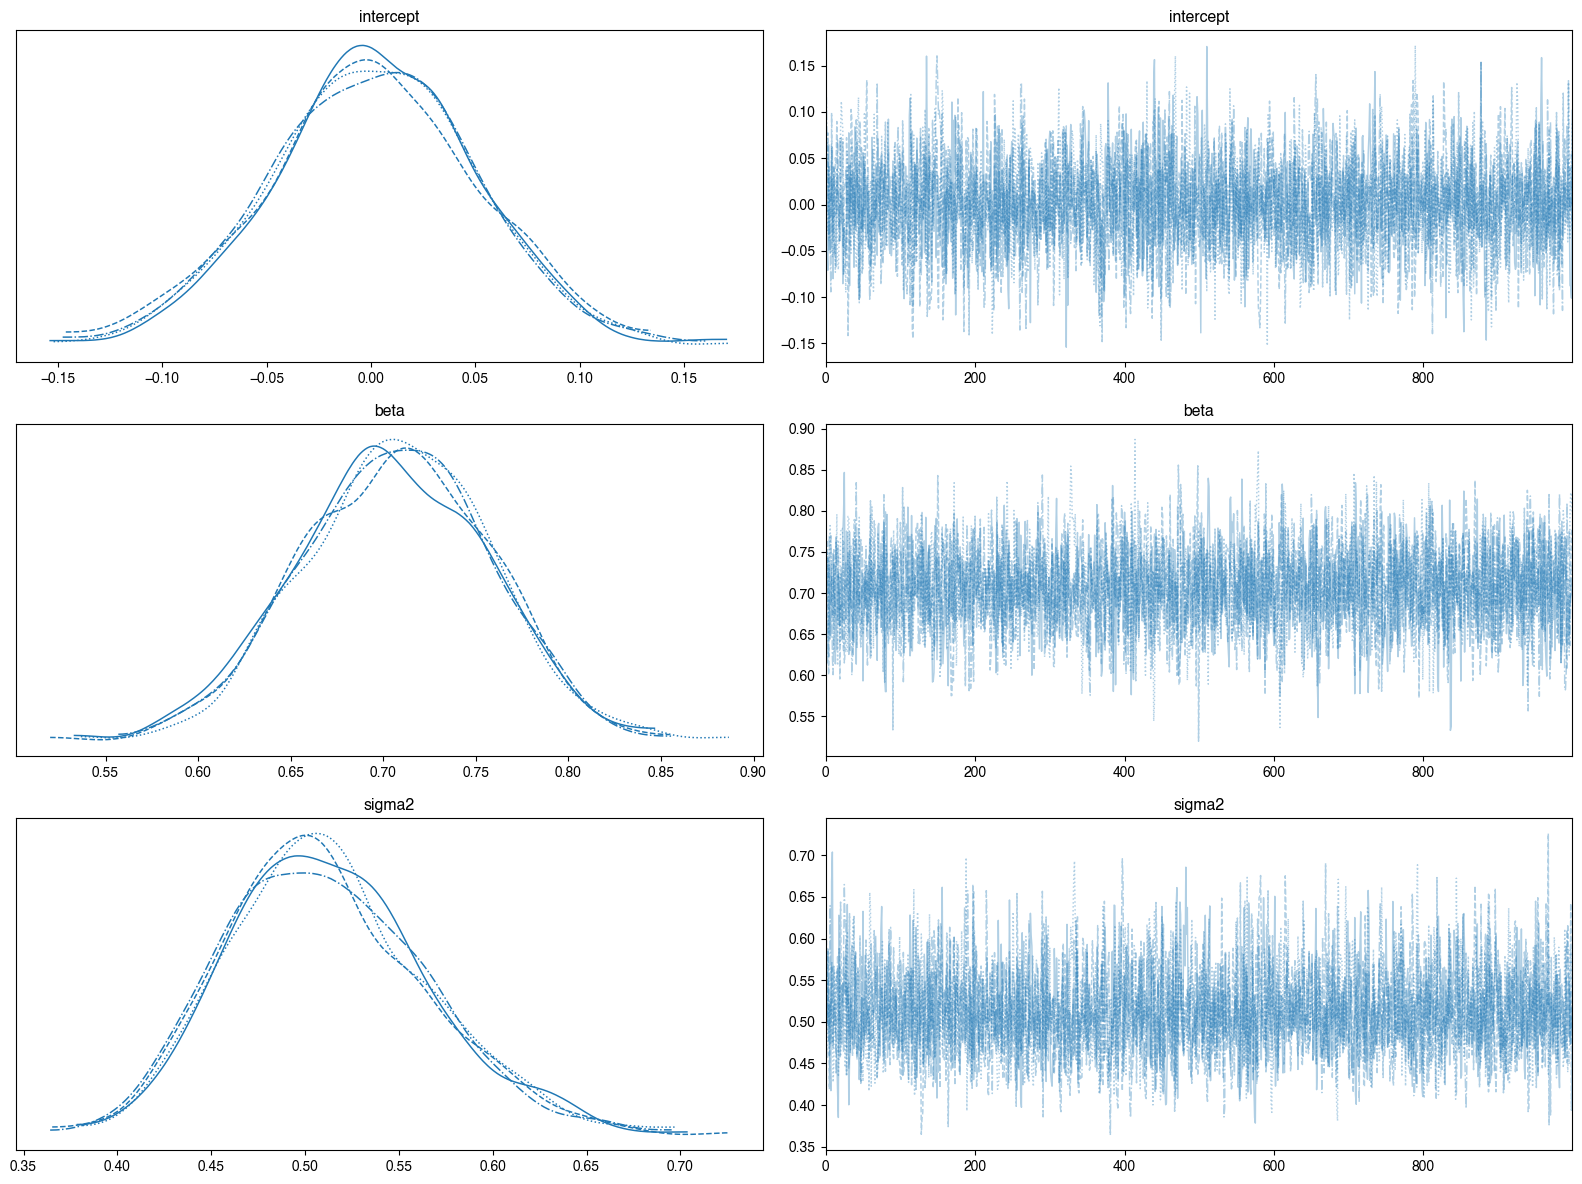

In [51]:
with bayesLassoUni:
    pm.plot_trace(trace, figsize = (16,12))

plt.tight_layout()
plt.show()

### Building the Frequentist Lasso Fit

In [67]:
# reshape for compatibility
X = x.values.reshape(-1,1)

# Lasso model
modelLasso = Lasso(alpha = lambd)
modelLasso.fit(X,y)
yhatLasso = model.predict(X)

### Comparing Bayesian with Frequenstist Lasso

/opt/anaconda3/lib/python3.8/site-packages/pymc3-3.11.4-py3.8.egg/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
/opt/anaconda3/lib/python3.8/site-packages/pymc3-3.11.4-py3.8.egg/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.


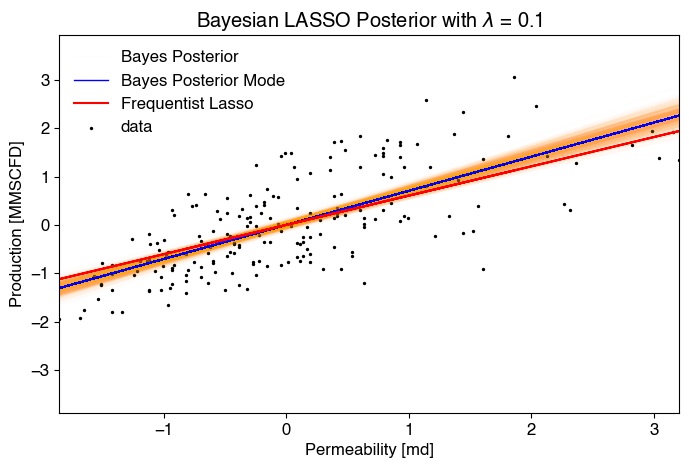

In [69]:
plt.figure(figsize = (8,5))
plt.scatter(x, y, color = "black", label = "data", s = 2)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(-4, 4, 100), linewidth = 1, color = 'orange', alpha = 0.01, 
                                 label = 'Bayes Posterior',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
pm.plot_posterior_predictive_glm(trace, samples = 1000, eval = np.linspace(-4, 4, 100), 
                                 linewidth = 1, color = 'blue',
                                 label = 'Bayes Posterior Mode',
                                 lm = lambda x, sample: posteriorMode['intercept'] + posteriorMode['beta'] * x)
plt.plot(x, yhatLasso, color = "red", label = "Frequentist Lasso")
plt.xlabel("Permeability [md]")
plt.ylabel("Production [MMSCFD]")
plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(lambd)
plt.title(plotTitle)
plt.xlim([min(x), max(x)])
plt.legend(frameon = False)
plt.show()

### The Effects of $\lambda$

**notice**

This might take a while.

In [108]:
lambdaList = [0.01, 0.1, 0.5, 100]

traceList = []
modeList = []

for l in lambdaList:
    with pm.Model() as bayesLassoUni:
        # declare priors
        intercept = pm.Flat("intercept")
        sigmaSq = pm.Exponential("sigma2", lam = 1)
        beta = pm.Laplace("beta", mu = 0, b = sigmaSq**0.5/l)

        # construct model
        modelMean = intercept + (beta * x)

        # define likelihood
        likelihood = pm.Normal('likelihood', mu = modelMean, sd = sigmaSq**0.5, observed = y)

        # set up posterior sampling 
        step = pm.NUTS(target_accept = 0.95)

        # get trace and maximum a posteriori (MAP)
        trace = pm.sample(draws = 1000, tune = 1000, step = step, 
                          random_seed = seed, return_inferencedata = True)
        posteriorMode = pm.find_MAP()
        
    traceList.append(trace)
    modeList.append(posteriorMode)
    

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [109]:
# Lasso model
yhatLassoList = []
for l in lambdaList:
    modelLasso = Lasso(alpha = l)
    modelLasso.fit(X,y)
    yhatLasso = modelLasso.predict(X)
    yhatLassoList.append(yhatLasso)

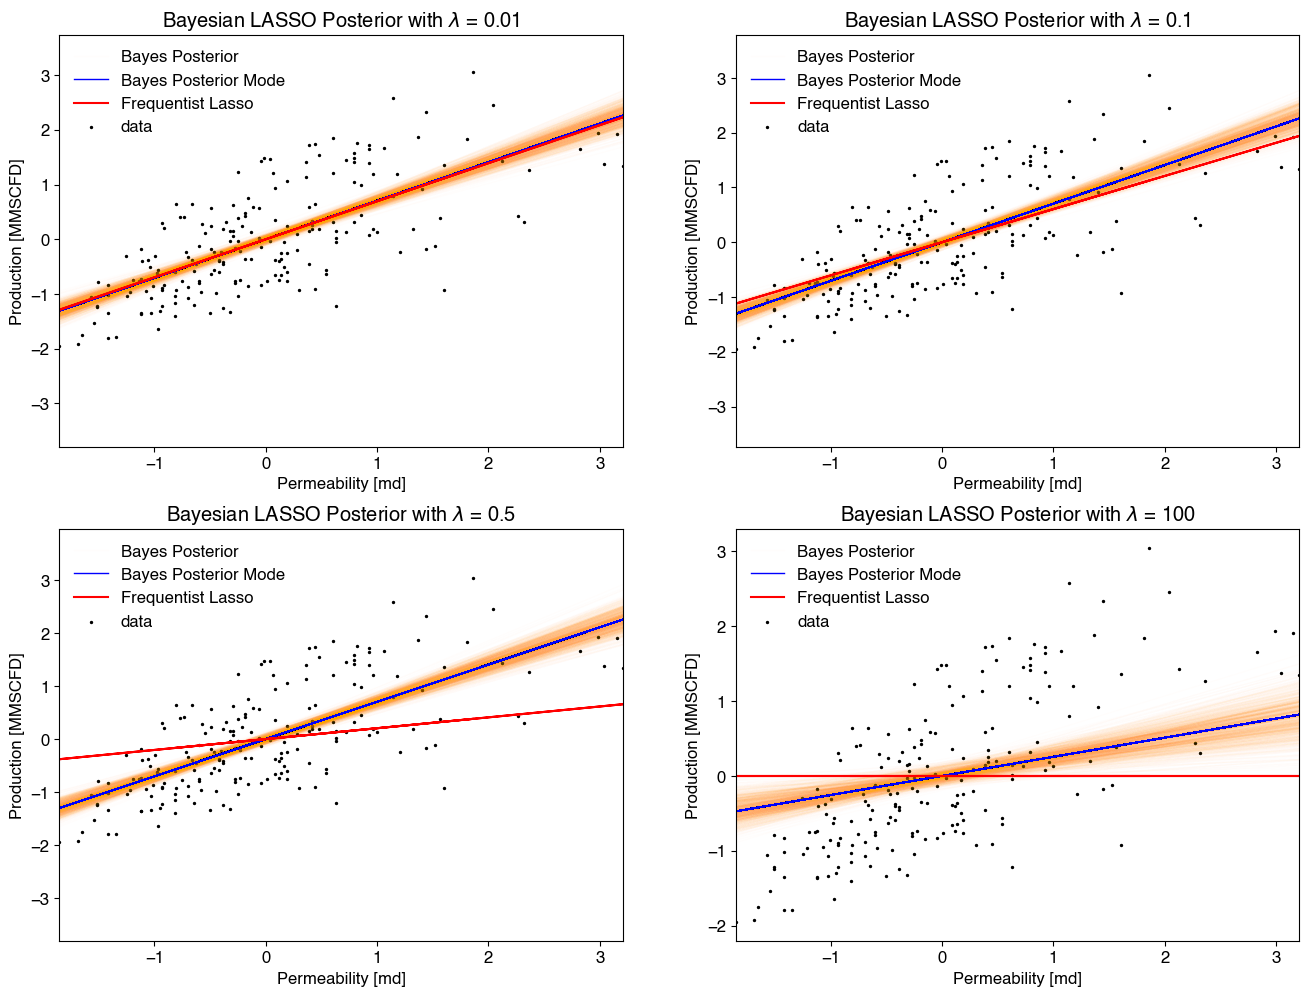

In [110]:
plt.figure(figsize = (16,12))
for idx,l in enumerate(lambdaList):
    plt.subplot(2,2,idx + 1)
    plt.scatter(x, y, color = "black", label = "data", s = 2)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(-4, 4, 100), linewidth = 1, color = 'orange', alpha = 0.01, 
                                     label = 'Bayes Posterior',lm = lambda x, sample: sample['intercept'] + sample['beta'] * x)
    pm.plot_posterior_predictive_glm(traceList[idx], samples = 1000, eval = np.linspace(-4, 4, 100), 
                                     linewidth = 1, color = 'blue',
                                     label = 'Bayes Posterior Mode',
                                     lm = lambda x, sample: modeList[idx]['intercept'] + modeList[idx]['beta'] * x)
    plt.plot(x, yhatLassoList[idx], color = "red", label = "Frequentist Lasso")
    plt.xlabel("Permeability [md]")
    plt.ylabel("Production [MMSCFD]")
    plotTitle = r"Bayesian LASSO Posterior with $\lambda$ = " + str(l)
    plt.title(plotTitle)
    plt.xlim([min(x), max(x)])
    plt.legend(frameon = False)
plt.show()